In [1]:
import torch
import math
from copy import deepcopy
import torchvision.models as models

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
model = models.__dict__['resnet50'](pretrained=False)

In [23]:
class SGDR(_LRScheduler):
    
    def __init__(self, optimizer, model, out_dir, T_max, T_multFactor, eta_min=0, last_epoch=-1, save_snapshot=False):
        
        self.last_epoch = last_epoch
        
        self.eta_min = eta_min
        self.T_multFactor = T_multFactor
        self.model = model
        
        self.T_max = T_max
        self.Te = T_max
        self.cur = -1 ## epochs since the last scheduler reset
        
        self.out_dir = out_dir
        self.optimizer = optimizer
        self.lr_history = []
        
        self.save_snapshot = save_snapshot
        
        super(SGDR, self).__init__(optimizer, last_epoch)
        
        
    def get_lr(self):
                
        new_lr = [self.eta_min + (base_lr - self.eta_min) * 1/2 * (1 + math.cos(math.pi * self.cur / (self.Te))) for base_lr in self.base_lrs]
        self.lr_history.append(new_lr)
        
        print(self.last_epoch, self.cur, self.Te, self.T_max, new_lr)
        
        return new_lr
        
    def step(self, epoch=None):
        
        ## initial step ex) sgdr.step()
        print("prev last epoch {}".format(self.last_epoch))
        if epoch is None:
            epoch = self.last_epoch + 1
            
#         print("last epoch {}".format(self.last_epoch))
        
        self.last_epoch = epoch
        
        self.cur += 1
        new_lr = self.get_lr()
    
        ## update optimizer's learning rate
        for param_group, lr in zip(self.optimizer.param_groups, new_lr):
            param_group['lr'] = lr
              
        ## restart if epochs since the last restart is equal to the target restart epochs
        if self.cur == self.Te:
            print(self.T_max, "--Restart: ", new_lr)
            
            if self.save_snapshot:
                print("save checkpoint: {}".format(self.last_epoch + 1))
                torch.save({
                    'epoch': self.T_max,
                    'state_dict': self.model.state_dict()
                }, self.out_dir + "/" + 'snapshop_e_{:03d}.pth.tar'.format(self.last_epoch))

            # reset cur
            self.cur = -1
            
            # increase Te by a factor of T_multFactor
            self.Te *= self.T_multFactor
            
            # update T_max with Te
            self.T_max += self.Te        

In [3]:
from torch.optim.lr_scheduler import _LRScheduler

In [11]:
class CosineAnnealingLR(_LRScheduler):
    r"""Set the learning rate of each parameter group using a cosine annealing
    schedule, where :math:`\eta_{max}` is set to the initial lr and
    :math:`T_{cur}` is the number of epochs since the last restart in SGDR:

    .. math::

        \eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 +
        \cos(\frac{T_{cur}}{T_{max}}\pi))

    When last_epoch=-1, sets initial lr as lr.

    It has been proposed in
    `SGDR: Stochastic Gradient Descent with Warm Restarts`_. Note that this only
    implements the cosine annealing part of SGDR, and not the restarts.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        T_max (int): Maximum number of iterations.
        eta_min (float): Minimum learning rate. Default: 0.
        last_epoch (int): The index of last epoch. Default: -1.

    .. _SGDR\: Stochastic Gradient Descent with Warm Restarts:
        https://arxiv.org/abs/1608.03983
    """

    def __init__(self, optimizer, T_max, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.eta_min = eta_min
        self.lr_history = []
        super(CosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        new_lrs = [self.eta_min + (base_lr - self.eta_min) *
                (1 + math.cos(math.pi * self.last_epoch / self.T_max)) / 2

                for base_lr in self.base_lrs]
        
        self.lr_history.append(new_lrs)
        return new_lrs

In [32]:
class CosineAnnealingLR_with_reset(_LRScheduler):
    r"""Set the learning rate of each parameter group using a cosine annealing
    schedule, where :math:`\eta_{max}` is set to the initial lr and
    :math:`T_{cur}` is the number of epochs since the last restart in SGDR:

    .. math::

        \eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 +
        \cos(\frac{T_{cur}}{T_{max}}\pi))

    When last_epoch=-1, sets initial lr as lr.

    It has been proposed in
    `SGDR: Stochastic Gradient Descent with Warm Restarts`_. Note that this only
    implements the cosine annealing part of SGDR, and not the restarts.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        T_max (int): Maximum number of iterations.
        eta_min (float): Minimum learning rate. Default: 0.
        last_epoch (int): The index of last epoch. Default: -1.

    .. _SGDR\: Stochastic Gradient Descent with Warm Restarts:
        https://arxiv.org/abs/1608.03983
    """

    def __init__(self, optimizer, T_max, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.eta_min = eta_min
        self.lr_history = []
        self.current_epoch = last_epoch
        super(CosineAnnealingLR_with_reset, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        new_lrs = [self.eta_min + (base_lr - self.eta_min) *
                (1 + math.cos(math.pi * self.current_epoch / self.T_max)) / 2

                for base_lr in self.base_lrs]
        
        self.lr_history.append(new_lrs)
        print(self.last_epoch, self.current_epoch, new_lrs)
        return new_lrs
    
    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        self.current_epoch += 1
        
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr
    
    

In [33]:
def simulate_lrs(optimizer, sgdr, epochs):
    for i in range(epochs):
        sgdr.step()
        lr = optimizer.param_groups[0]['lr']

    fig, ax = plt.subplots(figsize=(20, 4))
    ax.plot([x[0] for x in sgdr.lr_history])
    ax.set_yscale("log")
    plt.show()

0 0 [0.1]
0 1 [0.09755307053217621]
1 2 [0.0904518046337755]
2 3 [0.07939132368836221]
3 4 [0.0654543046337755]
4 5 [0.05000500000000001]
5 6 [0.03455569536622451]
6 7 [0.020618676311637812]
7 8 [0.009558195366224508]
8 9 [0.0024569294678237993]
9 10 [1e-05]


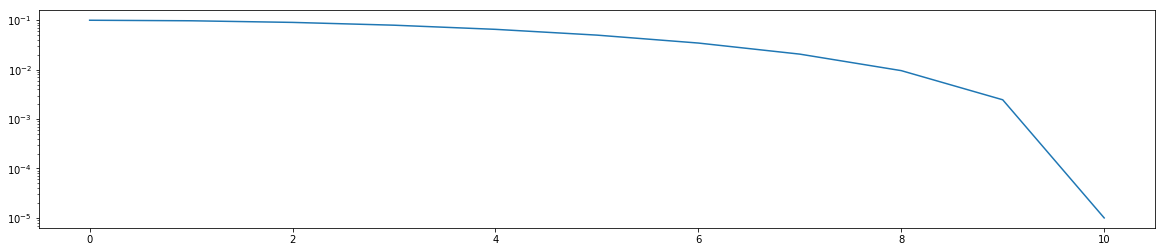

In [34]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# sgdr = SGDR(optimizer, model, 'res', 1, 2, eta_min=1e-5, last_epoch=-1)
sgdr = CosineAnnealingLR_with_reset(optimizer, T_max=10, eta_min=1e-5, last_epoch=-1)
simulate_lrs(optimizer, sgdr, 10)

prev last epoch -1
0 0 10 10 [0.1]
prev last epoch -1
0 1 10 10 [0.09755307053217621]
prev last epoch 0
1 2 10 10 [0.0904518046337755]
prev last epoch 1
2 3 10 10 [0.07939132368836221]
prev last epoch 2
3 4 10 10 [0.0654543046337755]
prev last epoch 3
4 5 10 10 [0.05000500000000001]
prev last epoch 4
5 6 10 10 [0.03455569536622451]
prev last epoch 5
6 7 10 10 [0.020618676311637812]
prev last epoch 6
7 8 10 10 [0.009558195366224508]
prev last epoch 7
8 9 10 10 [0.0024569294678237993]
prev last epoch 8
9 10 10 10 [1e-05]
10 --Restart:  [1e-05]
prev last epoch 9
10 0 20 30 [0.1]
prev last epoch 10
11 1 20 30 [0.09938447858805392]
prev last epoch 11
12 2 20 30 [0.09755307053217621]
prev last epoch 12
13 3 20 30 [0.09455087117679745]
prev last epoch 13
14 4 20 30 [0.0904518046337755]
prev last epoch 14
15 5 20 30 [0.08535680352542145]
prev last epoch 15
16 6 20 30 [0.07939132368836221]
prev last epoch 16
17 7 20 30 [0.07270225503447865]
prev last epoch 17
18 8 20 30 [0.0654543046337755]
pre

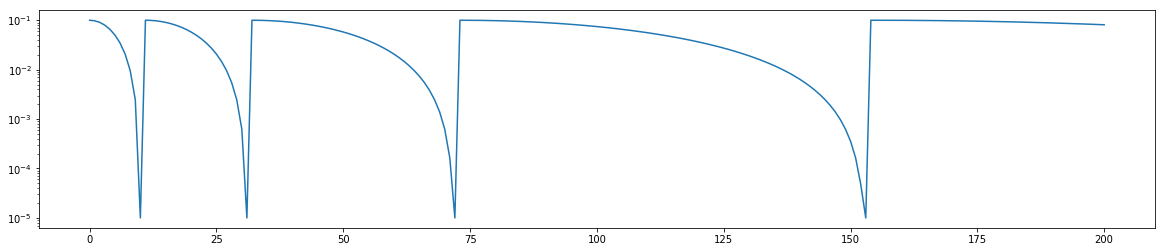

In [35]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
sgdr = SGDR(optimizer, model, 'res', 10, 2, eta_min=1e-5, last_epoch=-1)
simulate_lrs(optimizer, sgdr, 200)

prev last epoch -1
0 0 4 4 [0.1]
prev last epoch -1
0 1 4 4 [0.08535680352542145]
prev last epoch 0
1 2 4 4 [0.05000500000000001]
prev last epoch 1
2 3 4 4 [0.01465319647457856]
prev last epoch 2
3 4 4 4 [1e-05]
4 --Restart:  [1e-05]
prev last epoch 3
4 0 4 8 [0.1]
prev last epoch 4
5 1 4 8 [0.08535680352542145]
prev last epoch 5
6 2 4 8 [0.05000500000000001]
prev last epoch 6
7 3 4 8 [0.01465319647457856]
prev last epoch 7
8 4 4 8 [1e-05]
8 --Restart:  [1e-05]
prev last epoch 8
9 0 4 12 [0.1]
prev last epoch 9
10 1 4 12 [0.08535680352542145]
prev last epoch 10
11 2 4 12 [0.05000500000000001]
prev last epoch 11
12 3 4 12 [0.01465319647457856]
prev last epoch 12
13 4 4 12 [1e-05]
12 --Restart:  [1e-05]


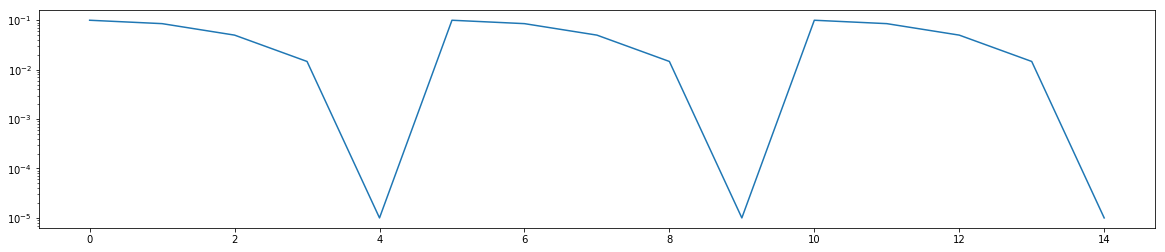

In [8]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
sgdr = SGDR(optimizer, model, 'res', 4, 1, eta_min=1e-5, last_epoch=-1)
simulate_lrs(optimizer, sgdr, 14)